## Assignment #1: 
This assignment deals with applying the BEM algorithm to learn the basic operation of a 
variable speed pitch regulated wind turbine.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
from scipy.integrate import quad

In [2]:
# Directory containing the files (current working directory)
current_dir = os.getcwd()  # gets the path of the folder where the code is run

# List of files
files = ['FFA-W3-2411.txt', 'FFA-W3-301.txt', 'FFA-W3-360.txt', 'FFA-W3-480.txt', 'FFA-W3-600.txt', 'cylinder.txt']
blade_data_filepath = os.path.join(current_dir, 'bladedat.txt')


# Overall data for the DTU 10 MW WT: 
R = 89.17                               # Rotor radius - m 
B = 3                                   # Number of blades
P_rated = 10.64                         # Rated electrical power - MW 
V_cutin = 4                             # Cut in wind speed - m/s 
V_cutout = 25                           # Cut out wind speed - m/s 
rho = 1.225                             # Air density ρ - kg/m3 
 
# The blade is described with following table
blade_data =pd.read_table(blade_data_filepath,names = ['r', 'beta', 'c', 't/c'], header=None)

In [3]:
blade_data.head()

,r,beta,c,t/c
0,2.800000,14.500000,5.380000,100.000000
1,11.002738,14.432009,5.452480,86.049148
2,16.871021,12.545974,5.866004,61.096958
3,22.964122,8.892452,6.184511,43.035645
4,32.307638,6.382198,6.019962,32.415053


In [4]:
# Defining functions to compute parameters
def compute_flow_angle(a, a_prime, Vo, omega, r):
    denominator = (1 + a_prime) * omega * r
    if np.isclose(denominator, 0):
        return 0  # Avoid division by zero, return a valid angle
    return math.atan((1 - a) * Vo / denominator)  # flow angle phi

def compute_solidity(B, c, r):
    return (B * c) / (2 * math.pi * r)  # solidity sigma

def compute_Vrel(Vo, omega, r):
    return math.sqrt(Vo**2 + (omega * r)**2)

def prandtl_tip_loss_factor(B, R, r, phi):
    sin_phi = np.sin(np.abs(phi))
    exp_term = np.exp(- (B / 2) * (R - r) / (r * sin_phi))
    return (2 / math.pi) * math.acos(exp_term)

def compute_aero_forces(Cl, Cd, phi):
    Cn = Cl * np.cos(phi) + Cd * np.sin(phi)
    Ct = Cl * np.sin(phi) - Cd * np.cos(phi)
    return Cn, Ct

def compute_thrust_coefficient(a, phi, Cn, sigma, F):
    sin_phi = np.sin(phi)
    if np.isclose(F, 0) or np.isclose(sin_phi, 0):
        return 0  # Avoid division by zero
    return ((1 - a)**2 * Cn * sigma) / (F * (sin_phi**2))

def compute_aero_forces(Cl, Cd, phi):
    Cn = Cl * np.cos(phi) + Cd * np.sin(phi)
    Ct = Cl * np.sin(phi) - Cd * np.cos(phi)
    return Cn, Ct

def update_a(a, f, dC_T):
    if a < 1/3:
        a_star = dC_T / (4 * (1 - a))
    else:
        a_star = dC_T / (4 * (1 - 0.25 * a * (5 - 3 * a)))
    return f * a_star + (1 - f) * a

def update_a_prime(a_prime, f, Ct, sigma, phi, F):
    if np.isclose(F, 0) or np.isclose(np.sin(phi) * np.cos(phi), 0):
        return 0  # Avoid division by zero
    a_prime_star = (Ct * sigma / (4 * F * np.sin(phi) * np.cos(phi))) * (1 + a_prime)
    return f * a_prime_star + (1 - f) * a_prime


## ****** INTERPOLATION OF COEFFICIENTS Cl AND Cd ********
# Initialize the arrays (assuming you already know the sizes of aoa_tab, cl_tab, cd_tab, cm_tab)
#Initializing tables    
cl_tab=np.zeros([105,6])
cd_tab=np.zeros([105,6])
cm_tab=np.zeros([105,6])
aoa_tab=np.zeros([105,])
# Read in the tables once at startup of simulation
for i in range(np.size(files)):
    file_path = os.path.join(current_dir, files[i])  # Create the full file path
    aoa_tab[:], cl_tab[:,i], cd_tab[:,i], cm_tab[:,i] = np.loadtxt(file_path, skiprows=0).T
# Thickness of the airfoils considered
# NOTE THAT IN PYTHON THE INTERPOLATION REQUIRES THAT THE VALUES INCREASE IN THE VECTOR!
thick_prof=np.zeros(6)
thick_prof[0]=24.1;
thick_prof[1]=30.1;
thick_prof[2]=36;
thick_prof[3]=48;
thick_prof[4]=60;
thick_prof[5]=100;
def force_coeffs_10MW(angle_of_attack,thick,aoa_tab,cl_tab,cd_tab,cm_tab):
    cl_aoa=np.zeros([1,6])
    cd_aoa=np.zeros([1,6])
    cm_aoa=np.zeros([1,6])
    #Interpolate to current angle of attack:
    for i in range(np.size(files)):
        cl_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cl_tab[:,i])
        cd_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cd_tab[:,i])
        cm_aoa[0,i]=np.interp (angle_of_attack,aoa_tab,cm_tab[:,i])
    
     #Interpolate to current thickness:
    cl=np.interp (thick,thick_prof,cl_aoa[0,:])
    cd=np.interp (thick,thick_prof,cd_aoa[0,:])
    cm=np.interp (thick,thick_prof,cm_aoa[0,:])
    return cl, cd, cm

In [5]:
def BEM(Vo, omega, theta_p):
    a, a_prime = 0.0, 0.0  # Step 1: Re-initialize a and a' for each iteration
    icount = 0  # Initialize iteration counter
    k = 0  # Loop control variable
    
    while k == 0:
        icount = icount + 1
        # Step 2: Compute the flowangle φ from
        phi = compute_flow_angle(a, a_prime, Vo, omega, r)
        # Step 3: Compute the local angle of attack by subtracting the twist and global pitch from the flow angle
        alpha = math.degrees(phi) - (beta + theta_p)  # Angle of attack
        # Step 4: Interpolate the Cl (α) and Cd(α)
        Cl, Cd, Cm = force_coeffs_10MW(alpha,thick,aoa_tab,cl_tab,cd_tab,cm_tab)
        # Step 5: Compute Cn and Ct 
        Cn, Ct = compute_aero_forces(Cl, Cd, phi)
        # Step 6: Compute the local thrust coefficient
        F = prandtl_tip_loss_factor(B, R, r, phi)
        sigma = compute_solidity(B, c, r)
        ## Updating a using Glauert correction
        dC_T = compute_thrust_coefficient(a, phi, Cn, sigma, F)
        # Step 7: Update a n and a’ n
        a_new = update_a(a, f, dC_T)
        # a_new = 0.246 * dC_T + 0.0586 * dC_T**2 + 0.0883 * dC_T**3
        a_prime_new = update_a_prime(a_prime, f, Ct, sigma, phi, F)
        # Step 8: If ǀan- an-1ǀ and ǀa’ n- a’ n-1ǀ larger than ε go back and recalculate
        if np.abs(a_new - a) < epsilon  and np.abs(a_prime_new - a_prime) < epsilon:
            k = 1  # Set k to 1 to exit the loop
        else:
            k = 0  # Set k to 0 to cotinue the loop
            
        # Check for maximum iterations
        if icount > 1000:
            print(f"Not converged for radius {r} with c {c} and beta {beta}.")
            k = 1  # Exit the loop if max iterations reached
        a = a_new
        a_prime = a_prime_new

    # Compute the local loads
    Vrel = compute_Vrel(Vo, omega, r)
    pn = 0.5 * rho * Vrel**2 * c * Cn
    pt = 0.5 * rho * Vrel**2 * c * Ct
    

    return pn, pt

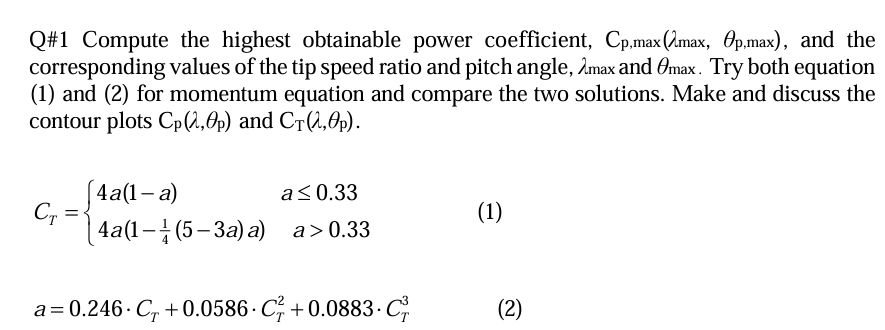

In [6]:
epsilon = 1e-6                      # Convergence tolerance
f = 0.1                             # relaxation factor
Vo = 10

tip_speed_ratio = np.arange(5, 11, 1)
theta_p =  np.arange(-4, 4, 1)

C_P = np.zeros((len(tip_speed_ratio), len(theta_p)))  # Initialize a 2D array for Cp & CT
C_T = np.zeros((len(tip_speed_ratio), len(theta_p))) 

# Nested for loop to go over each value combination of omega and theta_p
for j, tsr in enumerate(tip_speed_ratio):
    omega = (tsr * Vo) / R  # Calculate omega for the current tip speed ratio
    for i, theta in enumerate(theta_p):
        pn_values = []
        pt_values = []
        
        # Loop through each blade element
        for k in range(len(blade_data)):
            r = blade_data.iloc[k, 0]
            beta = blade_data.iloc[k, 1]
            c = blade_data.iloc[k, 2]
            thick = blade_data.iloc[k, 3]
            local_loads = BEM(Vo, omega, theta)  # Assume BEM function returns [pn, pt]
            pn_values.append(local_loads[0])
            pt_values.append(local_loads[1])

        # Calculate power and Cp
        power = omega * B * np.trapz(blade_data.iloc[:, 0] * pt_values, blade_data.iloc[:, 0])
        # print(" Power P: ", power/1e6, " MW at omega: ", omega, " rad/s and pitch theta_p: ", theta)
        C_P[j, i] = power / (0.5 * rho * (Vo**3) * np.pi * (R**2))
        thrust = B * np.trapz(pn_values, blade_data.iloc[:, 0])
        # print(" Thrust T: ", thrust, " at omega: ", omega, " rad/s and pitch theta_p: ", theta)
        C_T[j, i] = thrust / (0.5 * rho * (Vo**2) * np.pi * (R**2))
        # print("-" * 50)


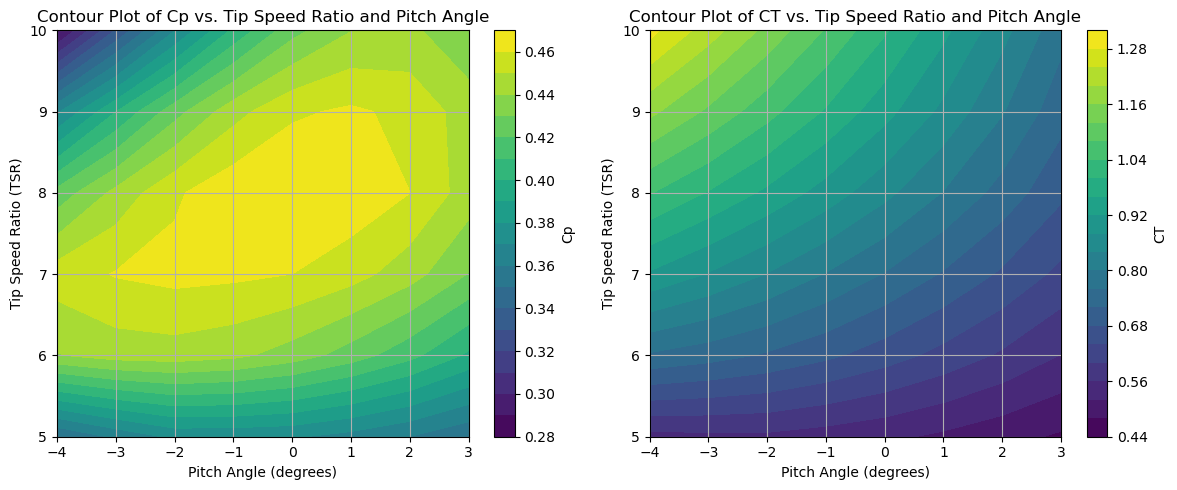

In [7]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Contour plot for Cp
X, Y = np.meshgrid(theta_p, tip_speed_ratio)
contour1 = axs[0].contourf(X, Y, C_P, levels=20, cmap='viridis')
fig.colorbar(contour1, ax=axs[0], label='Cp')
axs[0].set_title('Contour Plot of Cp vs. Tip Speed Ratio and Pitch Angle')
axs[0].set_xlabel('Pitch Angle (degrees)')
axs[0].set_ylabel('Tip Speed Ratio (TSR)')
axs[0].grid()

# Contour plot for CT
contour2 = axs[1].contourf(X, Y, C_T, levels=20, cmap='viridis')
fig.colorbar(contour2, ax=axs[1], label='CT')
axs[1].set_title('Contour Plot of CT vs. Tip Speed Ratio and Pitch Angle')
axs[1].set_xlabel('Pitch Angle (degrees)')
axs[1].set_ylabel('Tip Speed Ratio (TSR)')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
ind = np.unravel_index(np.argmax(C_P, axis=None), C_P.shape)
C_P_max = C_P[ind]
print(f'The highest obtainable power coefficient, Cp,max:  {C_P_max:.4f}')
print("The corresponding values of the tip speed ratio and pitch angle, λmax: " , tip_speed_ratio[ind[0]]," and θmax: ", theta_p[ind[1]])

The highest obtainable power coefficient, Cp,max:  0.4697
The corresponding values of the tip speed ratio and pitch angle, λmax:  8  and θmax:  0


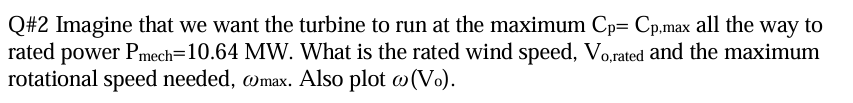

The rated power of 10.64 MW is first reached at a wind speed of 11.398 m/s, and the maximum angular speed is 1.023 rad/s.


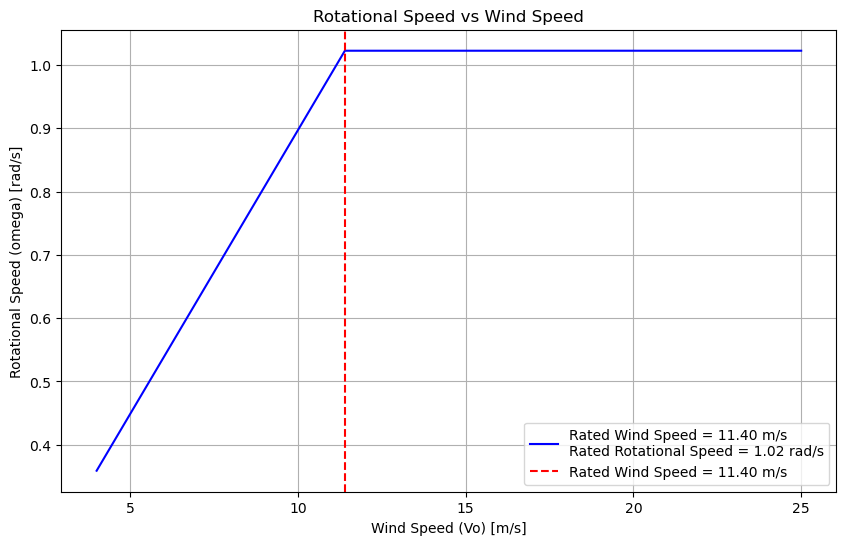

In [9]:
# Constants
Area = np.pi * R**2  # Rotor swept area
lambda_max = tip_speed_ratio[ind[0]]

# Finding rated wind speed
Vo_rated = (2 * P_rated*1e6 / (rho * Area * C_P_max)) ** (1/3)

# Finding rated rotational speed
omega_max = lambda_max * Vo_rated / R

print(f"The rated power of {P_rated} MW is first reached at a wind speed of {Vo_rated:.3f} m/s, "
      f"and the maximum angular speed is {omega_max:.3f} rad/s.")

# Wind speed range for plotting
Vo_range = np.linspace(4, 25, 1000)  # Wind speeds from cut-in to cut-out

# Defining omega as a function of Vo
omega = np.where(Vo_range < Vo_rated, lambda_max * Vo_range / R, omega_max)

# Plotting omega vs Vo
plt.figure(figsize=(10, 6))
plt.plot(Vo_range, omega, label=f'Rated Wind Speed = {Vo_rated:.2f} m/s\nRated Rotational Speed = {omega_max:.2f} rad/s', color='b')
plt.axvline(Vo_rated, color='r', linestyle='--', label=f'Rated Wind Speed = {Vo_rated:.2f} m/s')
plt.xlabel('Wind Speed (Vo) [m/s]')
plt.ylabel('Rotational Speed (omega) [rad/s]')
plt.title('Rotational Speed vs Wind Speed')
plt.legend()
plt.grid(True)
plt.show()


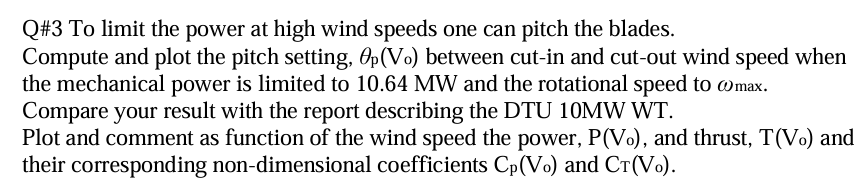

In [10]:
'''
# Plotting the power curve
fig1,axs1 = plt.subplots(1,2,figsize = (15,5))
plt.setp(axs1[0], title = 'Wind Turbine Power Curve', xlabel = 'Wind Speed (m/s)',ylabel = 'Power Output (MW)')
plt.setp(axs1[1], title = 'Angular Velocity (omega) vs Wind Speed (V_o)', xlabel = 'Wind Speed (m/s)',ylabel = 'Angular Velocity (rad/s)')
axs1[0].plot(V_range, P, color = 'red')
axs1[0].axhline(P_rated, color = 'royalblue', linestyle='--')
axs1[0].legend(['Power Output (MW)','Rated Power (10.64 MW)'])
axs1[0].grid(True)
axs1[1].plot(V_range, w, label='Angular Velocity (rad/s)', color='green')
axs1[1].grid(True)
plt.show()
'''

"\n# Plotting the power curve\nfig1,axs1 = plt.subplots(1,2,figsize = (15,5))\nplt.setp(axs1[0], title = 'Wind Turbine Power Curve', xlabel = 'Wind Speed (m/s)',ylabel = 'Power Output (MW)')\nplt.setp(axs1[1], title = 'Angular Velocity (omega) vs Wind Speed (V_o)', xlabel = 'Wind Speed (m/s)',ylabel = 'Angular Velocity (rad/s)')\naxs1[0].plot(V_range, P, color = 'red')\naxs1[0].axhline(P_rated, color = 'royalblue', linestyle='--')\naxs1[0].legend(['Power Output (MW)','Rated Power (10.64 MW)'])\naxs1[0].grid(True)\naxs1[1].plot(V_range, w, label='Angular Velocity (rad/s)', color='green')\naxs1[1].grid(True)\nplt.show()\n"

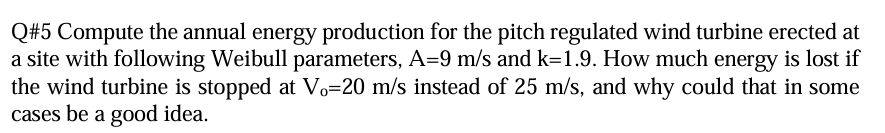

Annual Energy Production (AEP): 1.49 * 10^6 kWh for if wind turbine is stopped at 25 m/s
Annual Energy Production (AEP): 1.07 * 10^6 kWh for if wind turbine is stopped at 20 m/s
The amount of energy lost: 0.415 * 10^6 kWh


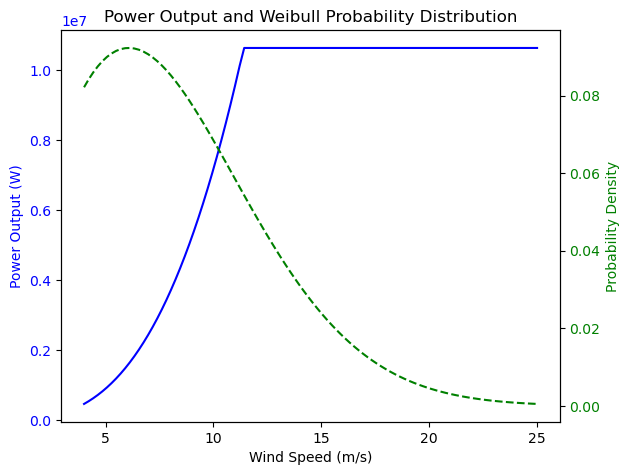

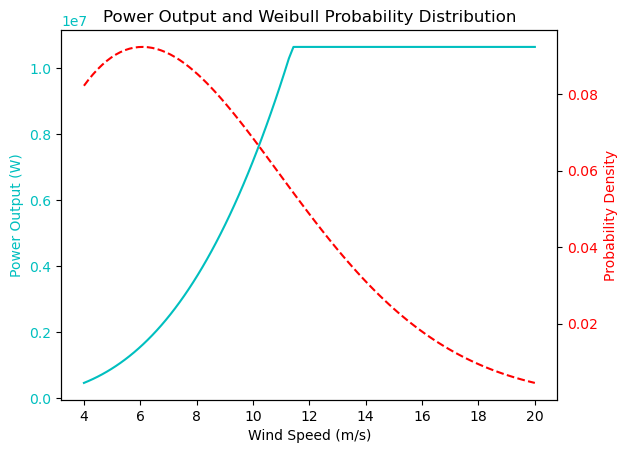

In [60]:
from scipy.stats import weibull_min

# Define Weibull distribution parameters
A = 9  # weibull_scale parameter 
k = 1.9  # weibull_shape parameter 

# Define wind speed range
wind_speeds = np.linspace(V_cutin, V_cutout, 100)  # Wind speeds from 4 to 25 m/s
V_cutout_new = 20
wind_speeds_new = np.linspace(V_cutin, V_cutout_new, 100)  # Wind speeds from 4 to 20 m/s


# Function to calculate probability density function f(V) for Weibull distribution
def weibull_pdf(v, scale, shape):
    #return np.exp(-(v/scale)**shape)
    return weibull_min.pdf(v, shape, scale=scale)

# Function to compute power for given wind speed
def compute_power(cp, wind_speed):
    return 0.5 * rho * Area * cp * wind_speed**3


# Assume we have power output values for each wind speed (use actual values in practice)
power_output = [compute_power(C_P_max, v) if v <= Vo_rated else (P_rated*1e6) for v in wind_speeds] # Cp,max from Q1 and Vo_rated from Q2

power_output_2 = [compute_power(C_P_max, v) if v <= Vo_rated else (P_rated*1e6) for v in wind_speeds_new]


# Calculate f(V) for each wind speed
probabilities = weibull_pdf(wind_speeds, A, k)
probabilities_new = weibull_pdf(wind_speeds_new, A, k)

# Calculate AEP using trapezoidal rule as shown in the equation
aep = 0
for i in range(len(wind_speeds) - 1):
    # Calculate the average power between two consecutive wind speeds
    avg_power = 0.5 * (power_output[i] + power_output[i + 1])
    # Calculate the probability of the wind speed range occurring
    prob = (probabilities[i] - probabilities[i + 1]) * (wind_speeds[i + 1] - wind_speeds[i])
    # Calculate the energy contribution for this wind speed range
    aep += avg_power * prob

aep_new = 0
for i in range(len(wind_speeds_new) - 1):
    # Calculate the average power between two consecutive wind speeds
    avg_power_new = 0.5 * (power_output_2[i] + power_output_2[i + 1])
    # Calculate the probability of the wind speed range occurring
    prob2 = (probabilities_new[i] - probabilities_new[i + 1]) * (wind_speeds_new[i + 1] - wind_speeds_new[i])
    # Calculate the energy contribution for this wind speed range
    aep_new += avg_power_new * prob2


# Multiply by the number of hours in a year (8760 hours)
aep *= 8760
aep_new *= 8760
energy_lost = aep - aep_new
# Print the AEP value
print(f"Annual Energy Production (AEP): {aep / 1e9:.2f} * 10^6 kWh for if wind turbine is stopped at 25 m/s")
print(f"Annual Energy Production (AEP): {aep_new / 1e9:.2f} * 10^6 kWh for if wind turbine is stopped at 20 m/s")
print(f"The amount of energy lost: {energy_lost / 1e9:.3f} * 10^6 kWh")

# Plot power output and probability distribution for visualization
fig, ax1 = plt.subplots()

ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Power Output (W)', color='b')
ax1.plot(wind_speeds, power_output, 'b-', label='Power Output')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Probability Density', color='g')
ax2.plot(wind_speeds, probabilities, 'g--', label='Probability Density')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.title('Power Output and Weibull Probability Distribution')
plt.show()


# Plot power output and probability distribution for visualization
fig2, ax2 = plt.subplots()

ax2.set_xlabel('Wind Speed (m/s)')
ax2.set_ylabel('Power Output (W)', color='c')
ax2.plot(wind_speeds_new, power_output_2, 'c-', label='Power Output')
ax2.tick_params(axis='y', labelcolor='c')

ax3 = ax2.twinx()
ax3.set_ylabel('Probability Density', color='r')
ax3.plot(wind_speeds_new, probabilities_new, 'r--', label='Probability Density')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Power Output and Weibull Probability Distribution')
plt.show()